<a href="https://colab.research.google.com/github/mahdimalverdi/DM-Project2/blob/main/DM_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [ ]:
!pip install vaderSentiment

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as sia
analyser = sia()

In [ ]:
!wget https://raw.githubusercontent.com/mahdimalverdi/DM-Project2/main/interactions.xlsx

--2021-07-03 14:06:40--  https://raw.githubusercontent.com/mahdimalverdi/DM-Project2/main/interactions.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13011069 (12M) [application/octet-stream]
Saving to: ‘interactions.xlsx’

interactions.xlsx   100%[===================>]  12.41M  --.-KB/s    in 0.1s    

2021-07-03 14:06:41 (83.0 MB/s) - ‘interactions.xlsx’ saved [13011069/13011069]



In [ ]:
!wget https://raw.githubusercontent.com/mahdimalverdi/DM-Project2/main/dataset.xls

--2021-07-03 14:14:00--  https://raw.githubusercontent.com/mahdimalverdi/DM-Project2/main/dataset.xls
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1161216 (1.1M) [application/octet-stream]
Saving to: ‘dataset.xls’

dataset.xls         100%[===================>]   1.11M  --.-KB/s    in 0.05s   

2021-07-03 14:14:00 (20.4 MB/s) - ‘dataset.xls’ saved [1161216/1161216]



In [44]:
interactions = pd.read_excel('interactions.xlsx')

In [107]:
dataset = pd.read_excel('dataset.xls')

In [45]:
def analyse(row):
    return analyser.polarity_scores(row['Extracted Interaction Text'])['compound']

interactions['compound'] = interactions.apply(analyse, axis=1)

In [108]:
compound_by_from_email_id = interactions.groupby(by=['fromEmailId'], dropna=False)['compound'].mean().to_dict()

def get_compound(row):
    return compound_by_from_email_id[row['SalesAgentEmailID']]

dataset['interaction_compound'] = dataset.apply(get_compound, axis=1)

In [117]:
def set_rate(key, column):
  won_count = dataset.groupby(by=[key], dropna=False).apply(lambda x : x[x['Stage'] == 'Won'].count())['Stage'].to_dict()
  count = dataset.groupby(by=[key], dropna=False).count()['Stage'].to_dict()

  def get_rate(row):
    return won_count[row[key]] / count[row[key]] 

  dataset[column] = dataset.apply(get_rate, axis=1)

In [118]:
set_rate('ContactEmailID', 'prod_acc_rate')
set_rate('SalesAgentEmailID', 'win_rate')
set_rate('Product', 'avg_sale_cyc')

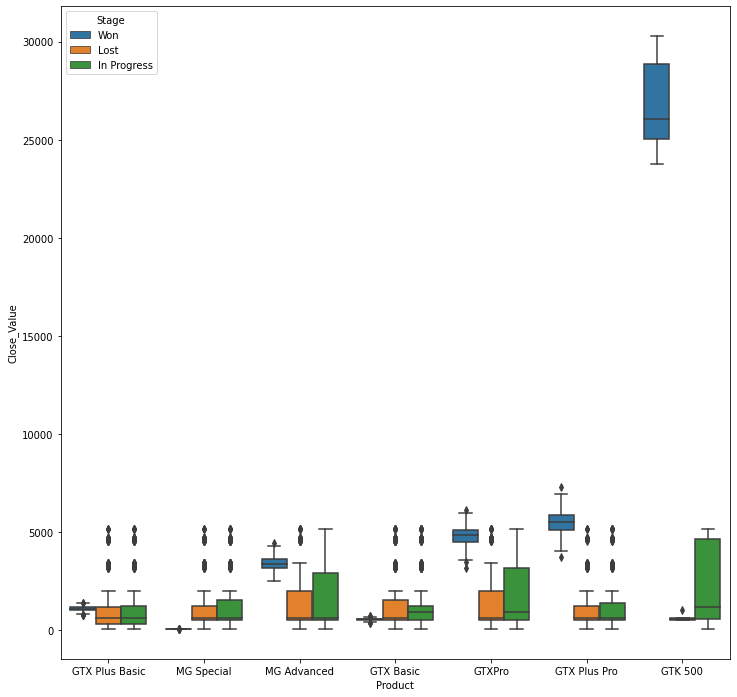

In [122]:
f, ax = plt.subplots(figsize=(12, 12))
sb.boxplot(x='Product',y='Close_Value',hue='Stage',data=dataset,ax=ax)

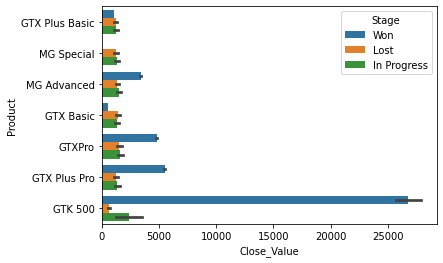

In [124]:
sb.barplot(y='Product',x='Close_Value',hue='Stage',data=dataset)

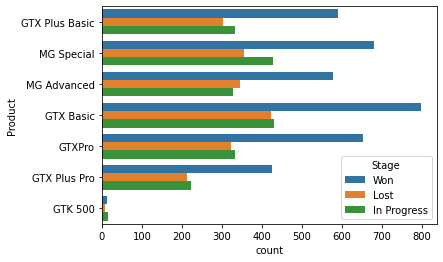

In [126]:
sb.countplot(y='Product',hue='Stage',data=dataset)

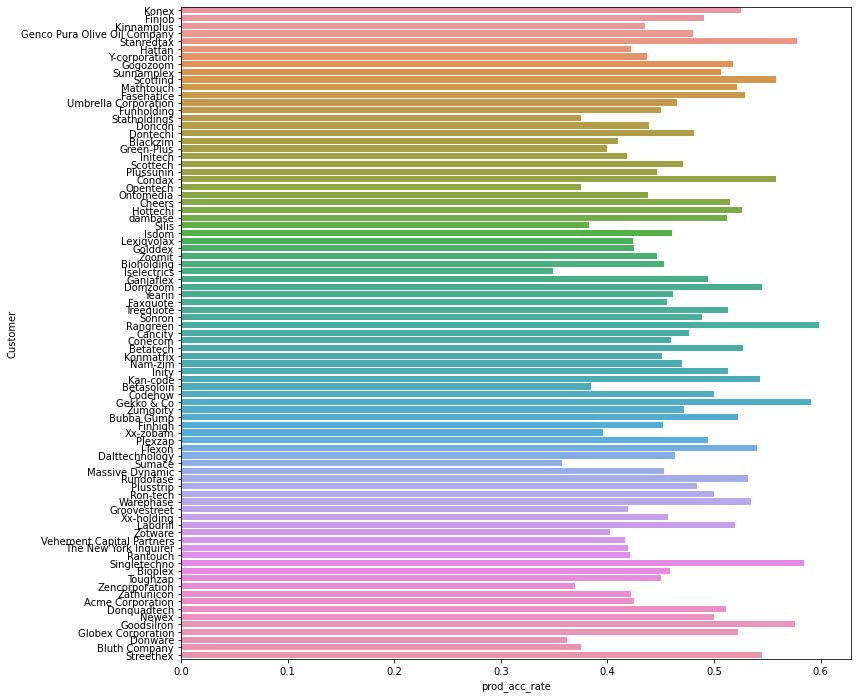

In [129]:
f, ax = plt.subplots(figsize=(12, 12))
sb.barplot(y='Customer',x='prod_acc_rate',data=dataset,ax=ax)